In [89]:
import numpy as np
import pandas as pd

In [90]:
# creating nodes
columns = ['coordinate_x','coordinate_y','u','v','Fx','Fy']
data = [[0,0,0,0,np.nan,np.nan],
        [0,10,0,0,np.nan,np.nan],
        [20,10,np.nan,np.nan,5000,0],
        [20,0,np.nan,np.nan,5000,0]]
nodes = pd.DataFrame(columns=columns,data=data)
nodes

,coordinate_x,coordinate_y,u,v,Fx,Fy
0,0,0,0.0,0.0,NaN,NaN
1,0,10,0.0,0.0,NaN,NaN
2,20,10,NaN,NaN,5000.0,0.0
3,20,0,NaN,NaN,5000.0,0.0


In [91]:
# creating elements
columns = ['n1','n2','n3','base','height','thickness']
data = [[0,2,1,10,20,1],
        [0,3,2,10,20,1]] # enter the nodes in same direction for all elements
elements = pd.DataFrame(data=data,columns=columns)
elements

,n1,n2,n3,base,height,thickness
0,0,2,1,10,20,1
1,0,3,2,10,20,1


In [92]:
E = 30e6
w = 0.3

# constitutive matrix for plane stress
D = (E/(1-w**2))*np.array([[1,w,0],[w,1,0],[0,0,(1-w)/2]])
D

array([[32967032.96703297,  9890109.89010989,        0.        ],
       [ 9890109.89010989, 32967032.96703297,        0.        ],
       [       0.        ,        0.        , 11538461.53846154]])

In [93]:
# areas of elements and betas and gammas
n = np.size(elements,axis=0)

def compute(e):
    b = np.zeros(3)
    g = np.zeros(3)
    p = e['n1']
    q = e['n2']
    r = e['n3']
    x1 = nodes.loc[p,'coordinate_x']
    y1 = nodes.loc[p,'coordinate_y']
    x2 = nodes.loc[q,'coordinate_x']
    y2 = nodes.loc[q,'coordinate_y']
    x3 = nodes.loc[r,'coordinate_x']
    y3 = nodes.loc[r,'coordinate_y']

    b[0] = y2-y3
    b[1] = y3-y1
    b[2] = y1-y2
    g[0] = x3-x2
    g[1] = x1-x3
    g[2] = x2-x1

    A = abs(0.5*np.linalg.det([[1,x1,y1],[1,x2,y2],[1,x3,y3]]))

    B = (1/(2*A))*np.array([[b[0],0.0,b[1],0.0,b[2],0.0],[0.0,g[0],0.0,g[1],0.0,g[2]],[g[0],b[0],g[1],b[1],g[2],b[2]]])

    return A, b, g, B
elements[['Area','beta','gamma','B']] = elements.apply(compute,axis=1,result_type='expand')
elements

,n1,n2,n3,base,height,thickness,Area,beta,gamma,B
0,0,2,1,10,20,1,100.0,"[0.0, 10.0, -10.0]","[-20.0, 0.0, 20.0]","[[0.0, 0.0, 0.049999999999999975, 0.0, -0.0499..."
1,0,3,2,10,20,1,100.0,"[-10.0, 10.0, 0.0]","[0.0, -20.0, 20.0]","[[-0.049999999999999975, 0.0, 0.04999999999999..."


In [94]:
# computing stiffness matrix
def comupe_k(e):
    t = e['thickness']
    A = e['Area']
    B = e['B']
    B_ = np.transpose(B)
    z = np.dot(B_,D)
    k = t*A*(np.dot(z,B))
    return k,A # needs to one dimensional to avoid error
elements[['k','Area']] = elements.apply(comupe_k,axis=1,result_type='expand')
elements

,n1,n2,n3,base,height,thickness,Area,beta,gamma,B,k
0,0,2,1,10,20,1,100.0,"[0.0, 10.0, -10.0]","[-20.0, 0.0, 20.0]","[[0.0, 0.0, 0.049999999999999975, 0.0, -0.0499...","[[11538461.538461534, 0.0, 0.0, -5769230.76923..."
1,0,3,2,10,20,1,100.0,"[-10.0, 10.0, 0.0]","[0.0, -20.0, 20.0]","[[-0.049999999999999975, 0.0, 0.04999999999999...","[[8241758.2417582385, 0.0, -8241758.2417582385..."


In [95]:
def compute_globalK(K,k,h,i,j):
    K[2*h,2*h] = K[2*h,2*h] + k[0,0]
    K[2*h,2*h+1] = K[2*h,2*h+1] + k[0,1]
    K[2*h,2*i] = K[2*h,2*i] + k[0,2]
    K[2*h,2*i+1] = K[2*h,2*i+1] + k[0,3]
    K[2*h,2*j] = K[2*h,2*j] + k[0,4]
    K[2*h,2*j+1] = K[2*h,2*j+1] + k[0,5]

    K[2*h+1,2*h] = K[2*h+1,2*h] + k[1,0]
    K[2*h+1,2*h+1] = K[2*h+1,2*h+1] + k[1,1]
    K[2*h+1,2*i] = K[2*h+1,2*i] + k[1,2]
    K[2*h+1,2*i+1] = K[2*h+1,2*i+1] + k[1,3]
    K[2*h+1,2*j] = K[2*h+1,2*j] + k[1,4]
    K[2*h+1,2*j+1] = K[2*h+1,2*j+1] + k[1,5]

    K[2*i,2*h] = K[2*i,2*h] + k[2,0]
    K[2*i,2*h+1] = K[2*i,2*h+1] + k[2,1]
    K[2*i,2*i] = K[2*i,2*i] + k[2,2]
    K[2*i,2*i+1] = K[2*i,2*i+1] + k[2,3]
    K[2*i,2*j] = K[2*i,2*j] + k[2,4]
    K[2*i,2*j+1] = K[2*i,2*j+1] + k[2,5]

    K[2*i+1,2*h] = K[2*i+1,2*h] + k[3,0]
    K[2*i+1,2*h+1] = K[2*i+1,2*h+1] + k[3,1]
    K[2*i+1,2*i] = K[2*i+1,2*i] + k[3,2]
    K[2*i+1,2*i+1] = K[2*i+1,2*i+1] + k[3,3]
    K[2*i+1,2*j] = K[2*i+1,2*j] + k[3,4]
    K[2*i+1,2*j+1] = K[2*i+1,2*j+1] + k[3,5]

    K[2*j,2*h] = K[2*j,2*h] + k[4,0]
    K[2*j,2*h+1] = K[2*j,2*h+1] + k[4,1]
    K[2*j,2*i] = K[2*j,2*i] + k[4,2]
    K[2*j,2*i+1] = K[2*j,2*i+1] + k[4,3]
    K[2*j,2*j] = K[2*j,2*j] + k[4,4]
    K[2*j,2*j+1] = K[2*j,2*j+1] + k[4,5]

    K[2*j+1,2*h] = K[2*j+1,2*h] + k[5,0]
    K[2*j+1,2*h+1] = K[2*j+1,2*h+1] + k[5,1]
    K[2*j+1,2*i] = K[2*j+1,2*i] + k[5,2]
    K[2*j+1,2*i+1] = K[2*j+1,2*i+1] + k[5,3]
    K[2*j+1,2*j] = K[2*j+1,2*j] + k[5,4]
    K[2*j+1,2*j+1] = K[2*j+1,2*j+1] + k[5,5]
    
    return K

m = np.size(nodes,axis=0)
K_ = np.zeros([m*2,m*2])
for a in range(0,np.size(elements,axis=0)):
    e = elements.loc[a]
    h = e['n1']
    i = e['n2']
    j = e['n3']
    k = e['k']
    K = np.zeros([m*2,m*2])
    K_ = K_ + compute_globalK(K,k,h,i,j)
K_

array([[ 19780219.78021977,         0.        , -11538461.53846153,
          5769230.76923077,         0.        , -10714285.71428571,
         -8241758.24175824,   4945054.94505494],
       [        0.        ,  35851648.35164834,   4945054.94505494,
        -32967032.96703295, -10714285.71428571,         0.        ,
          5769230.76923077,  -2884615.38461538],
       [-11538461.53846153,   4945054.94505494,  19780219.78021977,
        -10714285.71428571,  -8241758.24175824,   5769230.76923077,
                0.        ,         0.        ],
       [  5769230.76923077, -32967032.96703295, -10714285.71428571,
         35851648.35164834,   4945054.94505494,  -2884615.38461538,
                0.        ,         0.        ],
       [        0.        , -10714285.71428571,  -8241758.24175824,
          4945054.94505494,  19780219.78021977,         0.        ,
        -11538461.53846153,   5769230.76923077],
       [-10714285.71428571,         0.        ,   5769230.76923077,
       

In [96]:
def partition_K(K_,A,B):
    KAA = K_[np.ix_(A,A)]
    KAB = K_[np.ix_(A,B)]
    KBA = K_[np.ix_(B,A)]
    KBB = K_[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB

U = nodes[['u','v']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['Fx','Fy']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_K(K_, A, B)

In [97]:
# Known displacement, UB
UB = U[B]
# Known load, PA
PA = P[A]

UA = np.dot(np.linalg.inv(KAA),(PA - np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA,UA) + np.dot(KBB,UB)
P[B] = PB

In [98]:
results = nodes.copy()
results[['u','v']] = U.reshape(-1,2)
results[['Fx','Fy']] = P.reshape(-1,2)
results

,coordinate_x,coordinate_y,u,v,Fx,Fy
0,0,0,0.000000,0.000000,-5000.0,-3002.401922
1,0,10,0.000000,0.000000,-5000.0,3002.401922
2,20,10,0.000610,0.000004,5000.0,0.000000
3,20,0,0.000664,0.000104,5000.0,0.000000


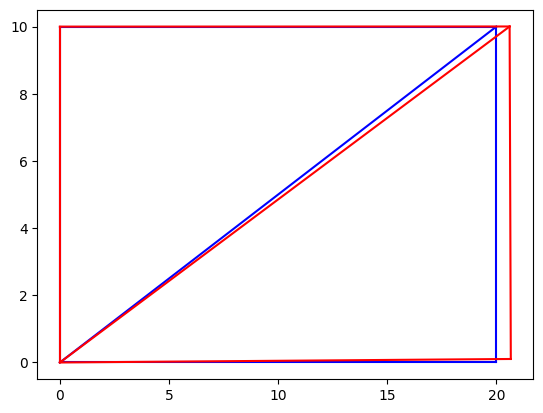

In [99]:
import matplotlib.pyplot as plt

for i in range(m-1):
    plt.plot(nodes.loc[i:i+1,'coordinate_x'],nodes.loc[i:i+1,'coordinate_y'],'b')
    if i==m-2:
        plt.plot(nodes.loc[[i+1,0],'coordinate_x'],nodes.loc[[i+1,0],'coordinate_y'],'b')
        plt.plot(nodes.loc[[i,0],'coordinate_x'],nodes.loc[[i,0],'coordinate_y'],'b')

factor = 1000
results['deformed_u'] = results['coordinate_x'] + factor*results['u']
results['deformed_v'] = results['coordinate_y'] + factor*results['v']
for i in range(m-1):
    plt.plot(results.loc[i:i+1,'deformed_u'],results.loc[i:i+1,'deformed_v'],'r')
    if i==m-2:
        plt.plot(results.loc[[i+1,0],'deformed_u'],results.loc[[i+1,0],'deformed_v'],'r')
        plt.plot(results.loc[[i,0],'deformed_u'],results.loc[[i,0],'deformed_v'],'r')

In [100]:
def compute_stress(e):
    B = e['B']
    h = e['n1']
    i = e['n2']
    j = e['n3']
    d = results.loc[[h,i,j],['u','v']].to_numpy()
    d = d.ravel()
    d = np.transpose(d)
    x = np.dot(D,B)
    stress = np.dot(x,d)
    return stress[0],stress[1],stress[2]
elements[['Stress_x','Stress_y','ShStress_xy']] = elements.apply(compute_stress,axis=1,result_type='expand')
elements

,n1,n2,n3,base,height,thickness,Area,beta,gamma,B,k,Stress_x,Stress_y,ShStress_xy
0,0,2,1,10,20,1,100.0,"[0.0, 10.0, -10.0]","[-20.0, 0.0, 20.0]","[[0.0, 0.0, 0.049999999999999975, 0.0, -0.0499...","[[11538461.538461534, 0.0, 0.0, -5769230.76923...",1004.803843,301.441153,2.401922
1,0,3,2,10,20,1,100.0,"[-10.0, 10.0, 0.0]","[0.0, -20.0, 20.0]","[[-0.049999999999999975, 0.0, 0.04999999999999...","[[8241758.2417582385, 0.0, -8241758.2417582385...",995.196157,-1.200961,-2.401922
